In [19]:
import numpy as np
from CrossSections import Transfer_SigmaV, Normalized_SigmaV, Transfer_sigma, Normalized_Transer, Transfer_Sigma_Low_Energy, Transfer_Sigmav_Low_Energy,  Integrand_Normalized_SigmaV, sigv_integrand_low
from scipy.optimize import minimize
import emcee
from Constants import c, fc

In [45]:
from scipy.integrate import quad

def Normalized_SigmaV2(v0, g, M, m):
    alpha = g**2/(4*np.pi)
    w = 300*(M/10)*(10/m)


    sigma0T = 137.86*(alpha/0.01)**2*(m/10)*(10/M)**4
    sigmaT = lambda v: 4*w**4/v**4 * (np.log(1 + v**2/(w**2)) - (v/w)**2/(1 + (v/w)**2) )

    sigma2_MB = v0**2*np.pi*(3*np.pi - 8)/np.pi
    vmax = 2*np.sqrt(sigma2_MB)
    integrand = lambda v: sigmaT(v)*(v/v0)*np.exp(-0.5*v**2/v0**2)*(v/v0)**2


    Prefactor = 4*np.pi*sigma0T/((2*np.pi)**1.5 )
    Integral = Prefactor*quad(integrand, 0.01, vmax)[0]

    
    return Integral


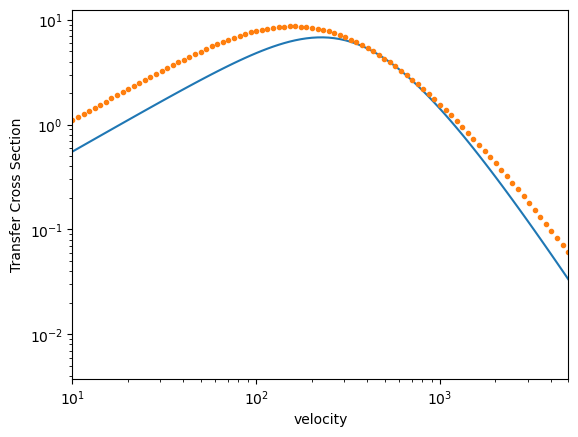

In [44]:
import matplotlib.pyplot as plt


v_array = np.logspace(1, 4, 100)
gprime = 0.04
mPhi = 10
mX = 10



#crossSection_array = [Transfer_Sigma_Low_Energy(v/c, g=gprime, M = 0.009, m=mX) for v in v_array] 
#normalized_cross_section_array = [Normalized_Transer(v, g = gprime, M = mPhi, m =mX) for v in v_array]

crossSection_array = [Transfer_SigmaV(v, g=gprime, M=mPhi/1000, m = mX) for v in v_array]
normalized_cross_section_array = [Normalized_SigmaV2(v, g=gprime, M=mPhi, m = mX) for v in v_array]
#PP_crosssection_array = [Transfer_SigmaV(v, g=gprime, M=mPhi, m=mX) for v in v_array]


plt.plot(v_array, crossSection_array)
plt.plot(v_array, normalized_cross_section_array, '.')
#plt.plot(v_array, PP_crosssection_array, '.')



plt.xlim([10, 5000])
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Transfer Cross Section')
plt.xlabel('velocity')
plt.show()

### Datos

Datos Camila

In [10]:
CamilaData_Fig7 = np.loadtxt('Data-Sets/Data_Fig7_Correa_2021.txt')
VelocityData = CamilaData_Fig7[:,0]
Velocity_16_Percentile = CamilaData_Fig7[:,1]
Velocity_84_Percentile = CamilaData_Fig7[:,2]
VelocityData_Err = ( (VelocityData - Velocity_16_Percentile) + (Velocity_84_Percentile - VelocityData) ) /2

CrossSectionData = CamilaData_Fig7[:,3]
CrossSectionData_16_Percentile = CamilaData_Fig7[:,4]
CrossSectionData_84_Percentile = CamilaData_Fig7[:,5]

CrossSectionData_Err = ((CrossSectionData - CrossSectionData_16_Percentile) + (CrossSectionData_84_Percentile - CrossSectionData) )/2


Datos Yu-Tulin

In [11]:
# For the fit
OrderedData = np.loadtxt('Data-Sets/Datos_ordenados.csv')
x_data = OrderedData[:,0]
y_data = OrderedData[:,1]
err_x_data = OrderedData[:,2]
err_y_data = OrderedData[:,3]


### Models

In [12]:


"""
////////////// Functions for the Fit //////////////////
"""
#Useful functions to use emcee
class mcmc_res:
    def __init__(self, sampler, x0=None):
        self.sampler = sampler
        self.flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
        self.x = []
        self.x_low = []
        self.x_high = []
        self.ndim = self.flat_samples.shape[1]
        for i in range(self.ndim):
            mcmc = np.percentile(self.flat_samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            self.x.append(mcmc[1])
            self.x_low.append(q[0])
            self.x_high.append(q[1])
        self.x0 = x0
        self.nonmarg_bestfit = sampler.flatchain[np.argmin(sampler.flatlnprobability)]
        
def run_mcmc(func_chi2, x0=None, bounds=None, nstep=5000, args=()):    
    assert x0 is not None, 'please, provide a first guess of the parameter values'
    assert bounds is not None, 'please, provide the boundaries of the parameter hyperspace'    
    def log_prior(theta, bounds):
        theta_l = list(theta)
        for i, pp in enumerate(theta_l):
            if (pp < bounds[i][0]) | (pp > bounds[i][1]):
                return -np.inf
        return 0    
    def log_likelihood(theta, *args):
        return -0.5 * func_chi2(theta, *args)    
    def log_probability(theta, *args):
        lp = log_prior(theta, bounds)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, *args)    
    #import emcee    
    ndim = len(x0)
    nwalkers = 4 * ndim    
    pos = x0 + 1e-4 * np.random.randn(nwalkers, ndim)    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=args)
    sampler.run_mcmc(pos, nstep, progress=True)    
    result = mcmc_res(sampler, x0=x0) 
    # Autocorrelation time
    #tau = sampler.get_autocorr_time()
    #print(tau)
    return result

In [13]:
# Define a chi square distribution to use as input in emcee
def compute_chi2(free_params, x=VelocityData, data=CrossSectionData, err=(VelocityData_Err, CrossSectionData_Err)):
    #Compute model
    M, m = free_params
    model = [Normalized_SigmaV2(x, gprime, M, m) for x in x]

    errx, erry = err
    #chi2 computation
    chi2y= np.sum((data-model)**2/erry**2)
    chi2x= np.sum((x - 2*x*np.sqrt(2/np.pi))**2/errx**2)
    return chi2y + chi2x

def compute_particle_chi2(free_params, x=VelocityData, data=CrossSectionData, err=(VelocityData_Err, CrossSectionData_Err)):
    #Compute model
    M, m = free_params
    model = [Transfer_SigmaV(x, gprime, M, m) for x in x]

    errx, erry = err
    #chi2 computation
    chi2y= np.sum((data-model)**2/erry**2)
    chi2x= np.sum((x - 2*x*np.sqrt(2/np.pi))**2/errx**2)
    return chi2y + chi2x

## Fits

### Fits with Camila Data

Fits for Transfer Cross section

In [14]:
data_args = (VelocityData, CrossSectionData, (VelocityData_Err, CrossSectionData_Err))
M_ini, m_ini = .01, 10
initial = [M_ini, m_ini]
bnds= [(0.001, 1000), (.1, 1000)]


bf_Norm = run_mcmc(compute_chi2, x0=initial, bounds=bnds)

bf_Norm.x

  2%|▏         | 100/5000 [00:09<02:23, 34.03it/s]C:\Users\Nicolás\AppData\Local\Temp\ipykernel_32036\1971290827.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = Prefactor*quad(integrand, 0.01, vmax)[0]
100%|██████████| 5000/5000 [01:03<00:00, 78.84it/s] 


[1.298379806849513, 3.202577722561431]

Fits for Transfer Cross section from PP

In [16]:
data_args = (VelocityData, CrossSectionData, (VelocityData_Err, CrossSectionData_Err))
M_ini, m_ini = .01, 10
initial = [M_ini, m_ini]
bnds= [(0.001, 1000), (.1, 1000)]


bf_Part = run_mcmc(compute_particle_chi2, x0=initial, bounds=bnds, args=data_args)

bf_Part.x

  1%|▏         | 70/5000 [00:06<10:01,  8.19it/s]d:\Nicolás\Documents\Research\Pre-Prints\Leptophilic-Atlas\Leptophilic-Atlas-Repo\Leptophilic-Atlas-Repo\CrossSections.py:181: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Integral = quad(Transfer_SigV_integrand, 0.0, vmax, args=(v0, g, M, m))[0]
  1%|▏         | 72/5000 [00:08<24:59,  3.29it/s]d:\Nicolás\Documents\Research\Pre-Prints\Leptophilic-Atlas\Leptophilic-Atlas-Repo\Leptophilic-Atlas-Repo\CrossSections.py:181: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Transfer_SigV_inte

[0.05084604447389779, 10.005926899868637]

import corner

truth = bfY.x
labels = ['M', 'm']
bounds = bnds

figure = corner.corner(
            bfY.flat_samples, labels=labels, title_kwargs={"fontsize": 12}, 
            label_kwargs={"fontsize": 12}, smooth=2, smooth1d=2, truths=truth,
            range=bounds, color='royalblue',
            levels=(0.39,0.68), plot_datapoints=False, show_titles=True
        )

### Fits with Yu Data

In [17]:

data_args = (x_data, y_data, (err_x_data, err_y_data))

M_ini, m_ini = 0.01, 100
initial = [M_ini, m_ini]
bnds= [(0.001, 100), (.01, 1000)]


bf_Yu = run_mcmc(compute_chi2, x0=initial, bounds=bnds, args=data_args)

bf_Yu.x

  5%|▍         | 231/5000 [00:36<05:34, 14.27it/s]C:\Users\Nicolás\AppData\Local\Temp\ipykernel_32036\1971290827.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = Prefactor*quad(integrand, 0.01, vmax)[0]
  5%|▌         | 256/5000 [00:37<04:03, 19.50it/s]C:\Users\Nicolás\AppData\Local\Temp\ipykernel_32036\1971290827.py:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Integral = Prefactor*quad(integrand, 0.01, vmax)[0]
100%|██████████| 5000/5000 [0

[1.9255362050005256, 1.146816433167123]

In [18]:
M_ini, m_ini = .01, 10
initial = [M_ini, m_ini]
bnds= [(0.001, 1000), (.1, 1000)]


bf_Yu_Part = run_mcmc(compute_particle_chi2, x0=initial, bounds=bnds, args=data_args)

bf_Yu_Part.x

  2%|▏         | 87/5000 [00:49<48:30,  1.69it/s]  d:\Nicolás\Documents\Research\Pre-Prints\Leptophilic-Atlas\Leptophilic-Atlas-Repo\Leptophilic-Atlas-Repo\CrossSections.py:181: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Transfer_SigV_integrand, 0.0, vmax, args=(v0, g, M, m))[0]
  2%|▏         | 97/5000 [00:54<37:15,  2.19it/s]d:\Nicolás\Documents\Research\Pre-Prints\Leptophilic-Atlas\Leptophilic-Atlas-Repo\Leptophilic-Atlas-Repo\CrossSections.py:181: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from

[0.0019256483281413727, 1.1465385394722207]

In [50]:


def Average_SigmaV(v0, g, M, m):
    M = M/1000
    Beta = v0/(2*c)
    s = 4 * m**2 / (1 - Beta**2)
    sigma0 = -g**4/(4*np.pi*s**3*Beta**4)
    
    # Attractive
    t_chn = -((s * Beta**2 * (-16 * m**4 - 6 * M**4 + 16 * m**2 * s - M**2 * s * (8 + 3 * Beta**2) + s**2 * (-4 - 4 * Beta**2 + Beta**4))) / (2 * (M**2 + s * Beta**2)))
    t_chn_log = - (8 * m**4 + 3 * M**4 - 8 * m**2 * s + 4 * M**2 * s + 2 * s**2)
    TR_t = t_chn + t_chn_log*np.log(1 + s*Beta**2/M**2)
    
    TA_s = -s**2 * Beta**4 * (24 * m**4 + 4 * m**2 * s * Beta**2 + s**2 * (3 - 2 * Beta**2)) / (6 * (M**2 - s)**2)

    ts_chn = - s*Beta**2 * (-24*m**4 + 6*(M**2 + s)**2 - 3*s*Beta**2*(2*s + M**2) + 2*s**2*Beta**4)/(6*(s-M**2))
    ts_chn_log = M**2 * ((s + M**2)**2 - 4*m**4)/(s-M**2)
    TA_st = ts_chn + ts_chn_log*np.log(1 + s*Beta**2/M**2)

    Transfer_sigma_attractive =  sigma0 / m  * (TR_t  + TA_s+ TA_st)

    # Repulsive
    u_chn = -((s * Beta**2 * (48 * m**4 + 6 * M**4 + 9 * M**2 * s * Beta**2 + 2 * s**2 * (1 + Beta**4) + 16 * m**2 * (2 * M**2 + s * (-1 + Beta**2)))) / (2 * M**2))
    u_chn_log = (24 * m**4 + s**2 + 3 * (M**2 + s * Beta**2)**2 + 8 * m**2 * (2 * M**2 + s * (-1 + 2 * Beta**2)) )
    TR_u = u_chn + u_chn_log*np.log(1 + s*Beta**2/M**2)
    
    tu_chn =  (s * Beta**2) / (2 * M**2 + s * Beta**2) * (12 * m**4 - 8 * m**2 * s + s**2)
    TR_tu = tu_chn*np.log(1 + s*Beta**2/M**2)

    Transfer_sigma_repulsive =  sigma0 / m  * ( TR_t  + TR_u - 2*TR_tu  ) 

    
    Transfer_sigma =  (Transfer_sigma_repulsive + Transfer_sigma_attractive)/2

    Integrand = lambda v: Transfer_sigma*(v/v0)*np.exp(-0.5*v**2/v0**2)*(v/v0)**2


    sigma2_MB = v0**2*np.pi*(3*np.pi - 8)/np.pi
    vmax = 2*np.sqrt(sigma2_MB)

    Prefactor = 4*np.pi/((2*np.pi)**1.5 )
    Integral = quad(Integrand, 0.0, vmax)[0]
    return fc* Prefactor*Integral

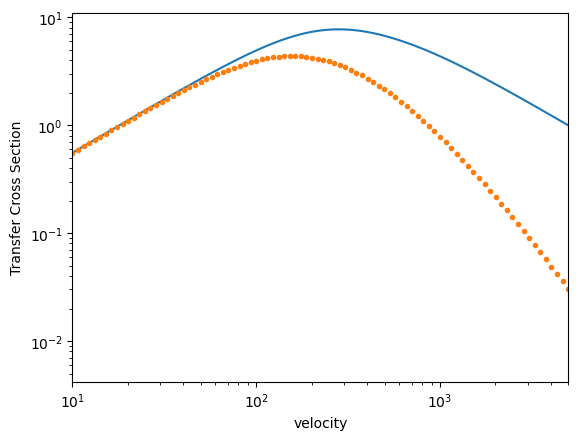

In [53]:
crossSection_array = [Average_SigmaV(v, g=gprime, M=mPhi, m = mX) for v in v_array]
normalized_cross_section_array = [Normalized_SigmaV2(v, g=gprime, M=mPhi, m = mX) for v in v_array]
#PP_crosssection_array = [Transfer_SigmaV(v, g=gprime, M=mPhi, m=mX) for v in v_array]


plt.plot(v_array, crossSection_array)
plt.plot(v_array, normalized_cross_section_array, '.')
#plt.plot(v_array, PP_crosssection_array, '.')



plt.xlim([10, 5000])
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Transfer Cross Section')
plt.xlabel('velocity')
plt.show()